## British Airways Customer Sentiment Analysis (by Yash Jain)
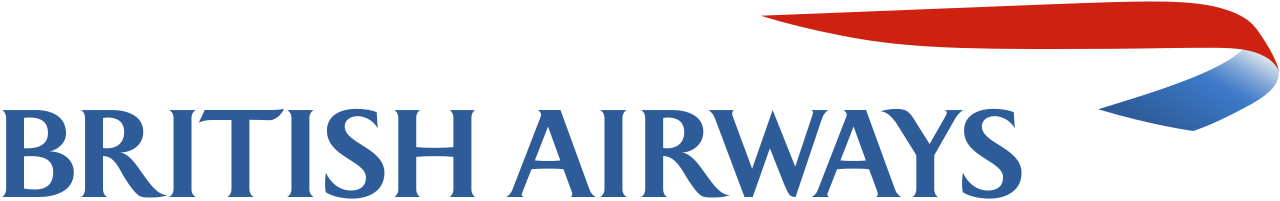

This project is part of the Forage Virtual Experience Program. The task at hand, is to analyze the customer reviews of British Airways, by scraping data from the website https://www.airlinequality.com/airline-reviews/british-airways/. 

The project would take up basic categorical and numerical analysis, before moving towards Sentiment Analysis. For that, further study needs to be done.

### 1. Data Extraction

Now, it comes to extracting our data. We will use asynchronous functions, which will handle multiple requests concurrently, to speed up the extraction process. 

### main

In [ ]:
import aiohttp
import asyncio
import pandas as pd
from bs4 import BeautifulSoup as bs
import nest_asyncio  # Fix for Jupyter Notebook

nest_asyncio.apply()  # Allow asyncio to work inside Jupyter

async def fetch_page(session, url):
    """Fetches a webpage asynchronously."""
    async with session.get(url) as response:
        return await response.text()
    
async def extract_column_names_from_page(session, url):
    """Extracts column names from a single page."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    columns = set()  # Store unique column names for this page
    review_sections = soup.find_all("div", class_="body")  # Find all reviews

    for review in review_sections:
        for row in review.find_all("tr"):  # Extract column names dynamically
            key_tag = row.find("td")  # First <td> contains column name
            if key_tag:
                column_name = key_tag.get_text(strip=True)
                columns.add(column_name)  # Add to the set

    return columns

async def extract_all_column_names(total_pages=393):
    """Extracts column names from all pages."""
    async with aiohttp.ClientSession() as session:
        tasks = [extract_column_names_from_page(session, BASE_URL.format(i)) for i in range(1, total_pages + 1)]
        all_columns_per_page = await asyncio.gather(*tasks)  # Run all page extractions concurrently

    # Finding unique columns across all pages
    all_columns = set().union(*all_columns_per_page)  # All unique columns

    return all_columns

async def extract_reviews_from_page(session, url, all_columns):
    """Extracts review data dynamically from a single page, fixing star ratings & overall rating."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    reviews_data = []  # Store structured review data

    # Find all reviews on the page
    review_sections = soup.find_all("article", itemprop="review")

    for review in review_sections:
        review_data = {col: None for col in all_columns}  # Initialize all values as None

        # Extract reviewer ID
        reviewer_div = review.find("div", id=True)  # Find the div that has an ID

        if reviewer_div:  # Ensure div exists
            review_id = reviewer_div.get("id")  # Extract the ID
            if review_id and review_id.startswith("anchor"):  # Check if it starts with 'anchor'
                review_id = review_id.replace("anchor", "")  # Remove 'anchor' prefix
            else:
                review_id = None  # If ID exists but is not formatted correctly
        else:
            review_id = None  # If no div with ID is found

        review_data["Review ID"] = review_id  # Store in dictionary

        
        # Extract review title
        title_tag = review.find("h2", class_="text_header")
        review_data["Review Title"] = title_tag.get_text(strip=True) if title_tag else None

        # Extract review metadata (author, date, etc.)
        meta_tag = review.find("h3", class_="text_sub_header userStatusWrapper")
        review_data["Review Meta"] = meta_tag.get_text(strip=True) if meta_tag else None

        # Extract review content
        content_tag = review.find("div", class_="text_content")
        review_data["Review Content"] = content_tag.get_text(strip=True) if content_tag else None

        # Extract overall rating
        rating_container = review.find("div", itemprop="reviewRating")  # Locate overall rating container
        review_data["Overall Rating"] = rating_container.get_text(strip=True).split("/")[0] if rating_container else None
 
        # ✅ Fix: Extract Star Ratings correctly
        for row in review.find_all("tr"):
            key_tag = row.find("td")  # First <td> contains column name
            value_tag = row.find("td", class_="review-value") or row.find("td", class_="stars")

            if key_tag:
                key = key_tag.get_text(strip=True)  # Parameter name

                if value_tag:
                    if "stars" in value_tag.get("class", []):  # If it's a star rating column
                        stars_filled = len(value_tag.find_all("span", class_="star fill"))  # Count filled stars ⭐
                        review_data[key] = stars_filled  # Assign numerical value (e.g., 4 stars → 4)
                    else:
                        review_data[key] = value_tag.get_text(strip=True)  # Assign text value

        reviews_data.append(review_data)  # Store review data

    return reviews_data

async def scrape_all_reviews(BASE_URL,total_pages=10):
    """Extracts all reviews dynamically and creates a structured DataFrame."""
    
    # Step 1: Extract all unique column names dynamically
    all_columns = await extract_all_column_names(total_pages)

    # Add fixed columns that will always be present
    all_columns.update(["Review ID", "Review Title", "Review Meta", "Review Content", "Overall Rating"])

    async with aiohttp.ClientSession() as session:
        tasks = [extract_reviews_from_page(session, BASE_URL.format(i), all_columns) for i in range(1, total_pages + 1)]
        all_reviews = await asyncio.gather(*tasks)  # Run all page extractions concurrently

    # Flatten the list (since gather returns a list of lists)
    all_reviews_flat = [review for page_reviews in all_reviews for review in page_reviews]

    # Convert to Pandas DataFrame
    df = pd.DataFrame(all_reviews_flat)

    return df

In [3]:
# Example usage: Scrape all reviews dynamically
BASE_URL = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/"
df_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews(BASE_URL,393))

# Display the DataFrame
df_reviews

,Value For Money,Review Content,Review Title,Route,Food & Beverages,Review Meta,Seat Type,Inflight Entertainment,Wifi & Connectivity,Type Of Traveller,Ground Service,Cabin Staff Service,Reviewer ID,Aircraft,Date Flown,Recommended,Overall Rating,Seat Comfort
0,4,✅Trip Verified| Flight mainly let down by a ...,"""disagreeable flight attendant""",Cape Town to London,5.0,10 reviewsJ Meares(United Kingdom)19th March 2025,Business Class,5.0,1.0,Solo Leisure,4.0,2.0,921004,Boeing 787,March 2025,yes,7,5.0
1,1,✅Trip Verified| Another awful experience by ...,"""flight was delayed nearly 1 hour""",London to Geneva,NaN,Luis De Jesus(United States)16th March 2025,Business Class,NaN,NaN,Business,1.0,1.0,920795,None,December 2024,no,1,1.0
2,1,"✅Trip Verified| The service was rude, full o...","""full of attitude to me""",London to New York,1.0,Luis De Jesus(United States)16th March 2025,Premium Economy,NaN,NaN,Business,5.0,1.0,920791,None,January 2025,no,3,1.0
3,1,✅Trip Verified| This flight was a joke. Ther...,"""service was outrageous""",Chambery to London,2.0,Luis De Jesus(United States)16th March 2025,Business Class,NaN,NaN,Business,1.0,1.0,920793,None,January 2025,no,1,1.0
4,5,✅Trip Verified| This time British Airways ma...,"""managed to get everything right""",Gatwick to Antigua,4.0,38 reviewsPaul Mercer(United Kingdom)7th March...,Premium Economy,4.0,4.0,Business,5.0,5.0,920342,Boeing 777,March 2025,yes,9,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,0,HKG-LHR in New Club World on Boeing 777-300 - ...,British Airways customer review,None,3.0,W Benson(United Kingdom)29th August 2012,Business Class,4.0,NaN,None,NaN,3.0,244110,None,None,yes,6,4.0
3920,3,LHR to HAM. Purser addresses all club passenge...,British Airways customer review,None,4.0,Nick Berry(United Kingdom)28th August 2012,Business Class,0.0,NaN,None,NaN,5.0,243823,None,None,yes,9,4.0
3921,4,My son who had worked for British Airways urge...,British Airways customer review,None,NaN,Avril Barclay(United Kingdom)12th October 2011,Economy Class,NaN,NaN,None,NaN,NaN,243776,None,None,yes,5,NaN
3922,1,London City-New York JFK via Shannon on A318 b...,British Airways customer review,None,5.0,C Volz(United States)11th October 2011,Premium Economy,0.0,NaN,None,NaN,3.0,243824,None,None,no,4,1.0


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3924 entries, 0 to 3923
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cabin Staff Service     3782 non-null   float64
 1   Seat Type               3922 non-null   object 
 2   Recommended             3924 non-null   object 
 3   Inflight Entertainment  2680 non-null   float64
 4   Reviewer ID             3924 non-null   object 
 5   Review Content          3924 non-null   object 
 6   Value For Money         3924 non-null   int64  
 7   Route                   3148 non-null   object 
 8   Seat Comfort            3797 non-null   float64
 9   Wifi & Connectivity     688 non-null    float64
 10  Date Flown              3146 non-null   object 
 11  Food & Beverages        3485 non-null   float64
 12  Aircraft                2044 non-null   object 
 13  Overall Rating          3919 non-null   object 
 14  Review Title            3924 non-null   

### checking for seat reviews

In [5]:
# Example usage: Scrape all reviews dynamically
BASE_URL = "https://www.airlinequality.com/seat-reviews/british-airways/page/{}/"
seat_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews(BASE_URL,20))

# Display the DataFrame
seat_reviews

,Seat/bed Width,Review Content,Power Supply,Seat Recline,Review Title,Viewing Tv Screen,Seat Layout,Review Meta,Seat Type,Aisle Space,...,Seat Privacy,Reviewer ID,Date Flown,Sitting Comfort,Seat Storage,Recommended,Seat/bed Length,Overall Rating,Aircraft Type,Seat Width
0,NaN,✅Trip Verified| Was sat on that famous row 3...,3.0,1.0,""" seat that doesn't recline by default""",3.0,3x3x3,E Junior(United Kingdom)19th December 2024,Economy Class,1.0,...,NaN,915121,December 2024,NaN,1.0,no,NaN,1,A350-1000,1.0
1,3.0,Not Verified| Recently flew BA’s nonstop bet...,NaN,NaN,"""too many seats in each row""",NaN,2x4x2,M Stanfield(United States)24th October 2024,Business Class,NaN,...,1.0,910893,October 2024,4.0,5.0,no,5.0,3,A380,NaN
2,NaN,Not Verified| Sat in seats 24a outbound to Bu...,1.0,1.0,"""Seats were both very worn""",NaN,3X3,Steven Tempest(United Kingdom)2nd September 2024,Economy Class,3.0,...,NaN,906454,September 2024,NaN,1.0,no,NaN,3,A320,2.0
3,1.0,✅Trip Verified| One of the worst business cla...,1.0,NaN,"""One of the worst business class seats""",NaN,2x3x2,Ruben Gindic(Mexico)16th May 2024,Business Class,NaN,...,4.0,895962,May 2024,2.0,5.0,no,3.0,3,Boeing 787,NaN
4,NaN,✅Trip Verified| BA doesn't seem to understand...,1.0,1.0,"""left with a horrible back pain""",NaN,3x3,A Ahmed(United Kingdom)7th May 2024,Economy Class,3.0,...,NaN,895201,April 2024,NaN,1.0,no,NaN,1,A320,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,World Traveller Plus cabin. Isle seat next to ...,NaN,2.0,British Airways customer review,1.0,2x4x2,B Edwards(United Kingdom)24th December 2008,Economy Class,3.0,...,NaN,276173,None,NaN,NaN,yes,NaN,6,B777,4.0
196,NaN,Euro Traveller OSL-LHR. After flying a lot of ...,NaN,2.0,British Airways customer review,1.0,3x3,Linda Brand(Norway)19th September 2008,Economy Class,3.0,...,NaN,276174,None,NaN,NaN,yes,NaN,6,A319,4.0
197,NaN,LHR-NBO The flight was not full and there were...,NaN,3.0,British Airways customer review,4.0,3x3x3,Simon Banister(South Africa)17th August 2008,Economy Class,2.0,...,NaN,276175,None,NaN,NaN,no,NaN,6,Boeing 747-400,3.0
198,NaN,9 hour flight from LGW to Orlando on outbound ...,NaN,3.0,British Airways customer review,4.0,3x3x3,Stephen Jacques(Ireland)13th August 2008,Economy Class,3.0,...,NaN,276176,None,NaN,NaN,yes,NaN,7,Boeing 777,3.0


In [13]:
seat_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Seat/bed Width     10 non-null     float64
 1   Review Content     200 non-null    object 
 2   Power Supply       61 non-null     float64
 3   Seat Recline       190 non-null    float64
 4   Review Title       200 non-null    object 
 5   Viewing Tv Screen  164 non-null    float64
 6   Seat Layout        200 non-null    object 
 7   Review Meta        200 non-null    object 
 8   Seat Type          200 non-null    object 
 9   Aisle Space        190 non-null    float64
 10  Sleep Comfort      10 non-null     float64
 11  Seat Legroom       190 non-null    float64
 12  Type Of Traveller  123 non-null    object 
 13  Seat Privacy       10 non-null     float64
 14  Reviewer ID        200 non-null    object 
 15  Date Flown         123 non-null    object 
 16  Sitting Comfort    10 non-

### lounge reviews

In [6]:
# Example usage: Scrape all reviews dynamically
BASE_URL = "https://www.airlinequality.com/lounge-reviews/british-airways/page/{}/"
lounge_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews(BASE_URL,43))

# Display the DataFrame
lounge_reviews

,Washrooms,Date Visit,Review Content,Cleanliness,Review Title,Catering,Review Meta,Airport,Staff Service,Bar & Beverages,Lounge Name,Type Of Traveller,Reviewer ID,Recommended,Wifi Connectivity,Comfort,Type Of Lounge,Overall Rating
0,1.0,March 2024,✅Trip Verified| The lounge is clean but the s...,3.0,"""there is not enough space""",3.0,20 reviewsE Carmere(Belgium)14th March 2024,Barbados Grantley Adams Airport,3.0,3.0,Business Class,Business,890761,yes,NaN,3.0,Business Class,6
1,5.0,December 2023,✅Trip Verified| The lounge is very spacious w...,5.0,"""Staff were welcoming and friendly""",5.0,Tony Maddern(Australia)21st December 2023,London Heathrow Airport,5.0,4.0,None,Business,883417,yes,5.0,5.0,Business Class,10
2,1.0,September 2023,"✅Trip Verified| Tatty and uncared for, the BA...",1.0,"""rotten and totally incompetent airline""",2.0,S Neale(United Kingdom)28th September 2023,London Gatwick Airport,1.0,2.0,South Terminal,Business,874680,no,3.0,1.0,Business Class,1
3,1.0,None,"✅Trip Verified| Crowded or rather ""overcrowde...",2.0,"""BA staff who are rude, abrasive""",2.0,Peter Glasier(United Kingdom)1st September 2023,London Heathrow Airport,2.0,3.0,First Lounge - T5,None,870736,no,2.0,2.0,First Class,2
4,4.0,June 2023,✅Trip Verified| Flew London to Kalamata and a...,4.0,"""full service has been resumed""",5.0,7 reviewsRichard Hodges(United Kingdom)20th Ju...,London Heathrow Airport,NaN,5.0,T5 Galleries South,Business,858802,yes,NaN,4.0,Business Class,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,NaN,None,I recently read a review on this website regar...,1.0,"""it had deteriorated even further""",1.0,James Pemberton(United Kingdom)11th August 2009,Jersey Airport,1.0,1.0,Club Europe,None,295648,no,2.0,2.0,None,1
417,4.0,None,Club Europe Lounge at Gatwick is very nice. It...,4.0,"""food selection is simple""",4.0,Fabrizio Ferraro(United Kingdom)30th July 2009,London Gatwick Airport,4.0,4.0,Club Europe / World Lounge,None,295649,no,4.0,4.0,None,4
418,4.0,None,Small but fine for the number of travellers on...,5.0,"""good atmosphere""",3.0,Simon Taylor(United Kingdom)30th July 2009,Montréal Airport,4.0,3.0,Club World,None,295650,no,4.0,4.0,None,4
419,2.0,None,Only food available was cheese and crackers. A...,2.0,"""decor is drab""",1.0,John Wilson(United Kingdom)15th July 2009,Antigua Vc Bird Airport,1.0,1.0,Club World,None,295651,no,NaN,2.0,None,1


In [14]:
lounge_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Washrooms          367 non-null    float64
 1   Date Visit         188 non-null    object 
 2   Review Content     421 non-null    object 
 3   Cleanliness        419 non-null    float64
 4   Review Title       421 non-null    object 
 5   Catering           412 non-null    float64
 6   Review Meta        421 non-null    object 
 7   Airport            415 non-null    object 
 8   Staff Service      405 non-null    float64
 9   Bar & Beverages    409 non-null    float64
 10  Lounge Name        268 non-null    object 
 11  Type Of Traveller  288 non-null    object 
 12  Reviewer ID        421 non-null    object 
 13  Recommended        421 non-null    object 
 14  Wifi Connectivity  374 non-null    float64
 15  Comfort            419 non-null    float64
 16  Type Of Lounge     392 non

### checking another thing - parametrizing total pages, airline and type of review. 

In [3]:
import aiohttp
import asyncio
import pandas as pd
from bs4 import BeautifulSoup as bs
import nest_asyncio  # Fix for Jupyter Notebook
import math

nest_asyncio.apply()  # Allow asyncio to work inside Jupyter

async def fetch_page(session, url):
    """Fetches a webpage asynchronously."""
    async with session.get(url) as response:
        return await response.text()

async def async_fetch_all_pages(fetch_function, BASE_URL, total_pages, *args):
    """
    Generic function to fetch data asynchronously from multiple pages.
    
    :param fetch_function: Function to call (either extract_columns or extract_reviews).
    :param BASE_URL: The URL template for requests.
    :param total_pages: Number of pages to scrape.
    :param args: Additional arguments required by the fetch function.
    """
    async with aiohttp.ClientSession() as session:
        tasks = [fetch_function(session, BASE_URL.format(i), *args) for i in range(1, total_pages + 1)]
        results = await asyncio.gather(*tasks)  # Fetch all pages concurrently

    return results

async def extract_column_names_from_page(session, url):
    """Extracts column names from a single page."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    columns = set()  # Store unique column names for this page
    review_sections = soup.find_all("div", class_="body")  # Find all reviews

    for review in review_sections:
        for row in review.find_all("tr"):  # Extract column names dynamically
            key_tag = row.find("td")  # First <td> contains column name
            if key_tag:
                column_name = key_tag.get_text(strip=True)
                columns.add(column_name)  # Add to the set

    return columns

async def extract_reviews_from_page(session, url, all_columns):
    """Extracts review data dynamically from a single page, fixing star ratings & overall rating."""
    html = await fetch_page(session, url)
    soup = bs(html, "html.parser")

    reviews_data = []  # Store structured review data

    # Find all reviews on the page
    review_sections = soup.find_all("article", itemprop="review")

    for review in review_sections:
        review_data = {col: None for col in all_columns}  # Initialize all values as None

        # Extract reviewer ID
        reviewer_div = review.find("div", id=True)  # Find the div that has an ID

        if reviewer_div:  # Ensure div exists
            review_id = reviewer_div.get("id")  # Extract the ID
            if review_id and review_id.startswith("anchor"):  # Check if it starts with 'anchor'
                review_id = review_id.replace("anchor", "")  # Remove 'anchor' prefix
            else:
                review_id = None  # If ID exists but is not formatted correctly
        else:
            review_id = None  # If no div with ID is found

        review_data["Review ID"] = review_id  # Store in dictionary

        
        # Extract review title
        title_tag = review.find("h2", class_="text_header")
        review_data["Review Title"] = title_tag.get_text(strip=True) if title_tag else None

        # Extract review metadata (author, date, etc.)
        meta_tag = review.find("h3", class_="text_sub_header userStatusWrapper")
        review_data["Review Meta"] = meta_tag.get_text(strip=True) if meta_tag else None

        # Extract review content
        content_tag = review.find("div", class_="text_content")
        review_data["Review Content"] = content_tag.get_text(strip=True) if content_tag else None

        # Extract overall rating
        rating_container = review.find("div", itemprop="reviewRating")  # Locate overall rating container
        review_data["Overall Rating"] = rating_container.get_text(strip=True).split("/")[0] if rating_container else None
 
        # ✅ Fix: Extract Star Ratings correctly
        for row in review.find_all("tr"):
            key_tag = row.find("td")  # First <td> contains column name
            value_tag = row.find("td", class_="review-value") or row.find("td", class_="stars")

            if key_tag:
                key = key_tag.get_text(strip=True)  # Parameter name

                if value_tag:
                    if "stars" in value_tag.get("class", []):  # If it's a star rating column
                        stars_filled = len(value_tag.find_all("span", class_="star fill"))  # Count filled stars ⭐
                        review_data[key] = stars_filled  # Assign numerical value (e.g., 4 stars → 4)
                    else:
                        review_data[key] = value_tag.get_text(strip=True)  # Assign text value

        reviews_data.append(review_data)  # Store review data

    return reviews_data

async def scrape_all_reviews(type='airline',airline='British Airways'):
    """Extracts all reviews dynamically and creates a structured DataFrame.
    
    :param type: Type of reviews to extract ('seat','lounge','airline').
    :param airline: Airline name to extract reviews for.

    :return: Structured DataFrame containing all reviews.
    """

    BASE_URL = "https://www.airlinequality.com/{type}/{airline}/page/{{}}/".format(type=type.lower()+"-reviews",
                                                                                   airline=airline.replace(" ","-").lower())

    #fetching number of pages to scrape
    async with aiohttp.ClientSession() as session:
        response = await session.get(BASE_URL.format(1))
        html = await response.text()
        soup = bs(html, "html.parser")
        nav = soup.find("span", itemprop="reviewCount")
        total_pages = math.ceil(int(nav.get_text(strip=True).split()[0])/10)
    
    print(f"Extracting {type} reviews of {airline} from {total_pages} pages...")

    # Step 1: Extract all unique column names dynamically
    all_columns = set().union(*await async_fetch_all_pages(extract_column_names_from_page, BASE_URL, total_pages))

    # Add fixed columns that will always be present
    all_columns.update(["Review ID", "Review Title", "Review Meta", "Review Content", "Overall Rating"])

    # Step 2: Extract all reviews from all pages
    all_reviews = await async_fetch_all_pages(extract_reviews_from_page, BASE_URL, total_pages, all_columns)
    
    # Flatten the list
    all_reviews_flat = [review for page_reviews in all_reviews for review in page_reviews]

    # Convert to Pandas DataFrame
    df = pd.DataFrame(all_reviews_flat)

    return df

In [ ]:
# Scrape all reviews dynamically
lounge_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews('lounge','British Airways'))
seat_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews('seat','British Airways'))
airline_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews())

# Display the DataFrames
display(
    lounge_reviews,
    seat_reviews,
    airline_reviews
)

Extracting lounge reviews of British Airways from 43 pages...
Extracting seat reviews of British Airways from 20 pages...
Extracting airline reviews of British Airways from 393 pages...


,Date Visit,Lounge Name,Overall Rating,Staff Service,Cleanliness,Review Content,Recommended,Wifi Connectivity,Type Of Traveller,Comfort,Washrooms,Bar & Beverages,Airport,Review Meta,Catering,Review Title,Review ID,Type Of Lounge
0,March 2024,Business Class,6,3.0,3.0,✅Trip Verified| The lounge is clean but the s...,yes,NaN,Business,3.0,1.0,3.0,Barbados Grantley Adams Airport,20 reviewsE Carmere(Belgium)14th March 2024,3.0,"""there is not enough space""",890761,Business Class
1,December 2023,None,10,5.0,5.0,✅Trip Verified| The lounge is very spacious w...,yes,5.0,Business,5.0,5.0,4.0,London Heathrow Airport,Tony Maddern(Australia)21st December 2023,5.0,"""Staff were welcoming and friendly""",883417,Business Class
2,September 2023,South Terminal,1,1.0,1.0,"✅Trip Verified| Tatty and uncared for, the BA...",no,3.0,Business,1.0,1.0,2.0,London Gatwick Airport,S Neale(United Kingdom)28th September 2023,2.0,"""rotten and totally incompetent airline""",874680,Business Class
3,None,First Lounge - T5,2,2.0,2.0,"✅Trip Verified| Crowded or rather ""overcrowde...",no,2.0,None,2.0,1.0,3.0,London Heathrow Airport,Peter Glasier(United Kingdom)1st September 2023,2.0,"""BA staff who are rude, abrasive""",870736,First Class
4,June 2023,T5 Galleries South,9,NaN,4.0,✅Trip Verified| Flew London to Kalamata and a...,yes,NaN,Business,4.0,4.0,5.0,London Heathrow Airport,7 reviewsRichard Hodges(United Kingdom)20th Ju...,5.0,"""full service has been resumed""",858802,Business Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,None,Club Europe,1,1.0,1.0,I recently read a review on this website regar...,no,2.0,None,2.0,NaN,1.0,Jersey Airport,James Pemberton(United Kingdom)11th August 2009,1.0,"""it had deteriorated even further""",295648,None
417,None,Club Europe / World Lounge,4,4.0,4.0,Club Europe Lounge at Gatwick is very nice. It...,no,4.0,None,4.0,4.0,4.0,London Gatwick Airport,Fabrizio Ferraro(United Kingdom)30th July 2009,4.0,"""food selection is simple""",295649,None
418,None,Club World,4,4.0,5.0,Small but fine for the number of travellers on...,no,4.0,None,4.0,4.0,3.0,Montréal Airport,Simon Taylor(United Kingdom)30th July 2009,3.0,"""good atmosphere""",295650,None
419,None,Club World,1,1.0,2.0,Only food available was cheese and crackers. A...,no,NaN,None,2.0,2.0,1.0,Antigua Vc Bird Airport,John Wilson(United Kingdom)15th July 2009,1.0,"""decor is drab""",295651,None


,Sleep Comfort,Review ID,Seat Legroom,Overall Rating,Viewing Tv Screen,Review Content,Seat Recline,Seat Type,Seat Layout,Recommended,...,Aircraft Type,Aisle Space,Date Flown,Sitting Comfort,Seat/bed Width,Review Meta,Review Title,Seat/bed Length,Power Supply,Seat Storage
0,NaN,915121,1.0,1,3.0,✅Trip Verified| Was sat on that famous row 3...,1.0,Economy Class,3x3x3,no,...,A350-1000,1.0,December 2024,NaN,NaN,E Junior(United Kingdom)19th December 2024,""" seat that doesn't recline by default""",NaN,3.0,1.0
1,1.0,910893,NaN,3,NaN,Not Verified| Recently flew BA’s nonstop bet...,NaN,Business Class,2x4x2,no,...,A380,NaN,October 2024,4.0,3.0,M Stanfield(United States)24th October 2024,"""too many seats in each row""",5.0,NaN,5.0
2,NaN,906454,1.0,3,NaN,Not Verified| Sat in seats 24a outbound to Bu...,1.0,Economy Class,3X3,no,...,A320,3.0,September 2024,NaN,NaN,Steven Tempest(United Kingdom)2nd September 2024,"""Seats were both very worn""",NaN,1.0,1.0
3,1.0,895962,NaN,3,NaN,✅Trip Verified| One of the worst business cla...,NaN,Business Class,2x3x2,no,...,Boeing 787,NaN,May 2024,2.0,1.0,Ruben Gindic(Mexico)16th May 2024,"""One of the worst business class seats""",3.0,1.0,5.0
4,NaN,895201,1.0,1,NaN,✅Trip Verified| BA doesn't seem to understand...,1.0,Economy Class,3x3,no,...,A320,3.0,April 2024,NaN,NaN,A Ahmed(United Kingdom)7th May 2024,"""left with a horrible back pain""",NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,276173,4.0,6,1.0,World Traveller Plus cabin. Isle seat next to ...,2.0,Economy Class,2x4x2,yes,...,B777,3.0,None,NaN,NaN,B Edwards(United Kingdom)24th December 2008,British Airways customer review,NaN,NaN,NaN
196,NaN,276174,4.0,6,1.0,Euro Traveller OSL-LHR. After flying a lot of ...,2.0,Economy Class,3x3,yes,...,A319,3.0,None,NaN,NaN,Linda Brand(Norway)19th September 2008,British Airways customer review,NaN,NaN,NaN
197,NaN,276175,3.0,6,4.0,LHR-NBO The flight was not full and there were...,3.0,Economy Class,3x3x3,no,...,Boeing 747-400,2.0,None,NaN,NaN,Simon Banister(South Africa)17th August 2008,British Airways customer review,NaN,NaN,NaN
198,NaN,276176,3.0,7,4.0,9 hour flight from LGW to Orlando on outbound ...,3.0,Economy Class,3x3x3,yes,...,Boeing 777,3.0,None,NaN,NaN,Stephen Jacques(Ireland)13th August 2008,British Airways customer review,NaN,NaN,NaN


,Aircraft,Value For Money,Review ID,Ground Service,Inflight Entertainment,Overall Rating,Review Content,Food & Beverages,Seat Type,Recommended,Type Of Traveller,Date Flown,Seat Comfort,Wifi & Connectivity,Review Meta,Cabin Staff Service,Review Title,Route
0,Boeing 787,4,921004,4.0,5.0,7,✅Trip Verified| Flight mainly let down by a ...,5.0,Business Class,yes,Solo Leisure,March 2025,5.0,1.0,10 reviewsJ Meares(United Kingdom)19th March 2025,2.0,"""disagreeable flight attendant""",Cape Town to London
1,None,1,920795,1.0,NaN,1,✅Trip Verified| Another awful experience by ...,NaN,Business Class,no,Business,December 2024,1.0,NaN,Luis De Jesus(United States)16th March 2025,1.0,"""flight was delayed nearly 1 hour""",London to Geneva
2,None,1,920791,5.0,NaN,3,"✅Trip Verified| The service was rude, full o...",1.0,Premium Economy,no,Business,January 2025,1.0,NaN,Luis De Jesus(United States)16th March 2025,1.0,"""full of attitude to me""",London to New York
3,None,1,920793,1.0,NaN,1,✅Trip Verified| This flight was a joke. Ther...,2.0,Business Class,no,Business,January 2025,1.0,NaN,Luis De Jesus(United States)16th March 2025,1.0,"""service was outrageous""",Chambery to London
4,Boeing 777,5,920342,5.0,4.0,9,✅Trip Verified| This time British Airways ma...,4.0,Premium Economy,yes,Business,March 2025,5.0,4.0,38 reviewsPaul Mercer(United Kingdom)7th March...,5.0,"""managed to get everything right""",Gatwick to Antigua
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,None,0,244110,NaN,4.0,6,HKG-LHR in New Club World on Boeing 777-300 - ...,3.0,Business Class,yes,None,None,4.0,NaN,W Benson(United Kingdom)29th August 2012,3.0,British Airways customer review,None
3920,None,3,243823,NaN,0.0,9,LHR to HAM. Purser addresses all club passenge...,4.0,Business Class,yes,None,None,4.0,NaN,Nick Berry(United Kingdom)28th August 2012,5.0,British Airways customer review,None
3921,None,4,243776,NaN,NaN,5,My son who had worked for British Airways urge...,NaN,Economy Class,yes,None,None,NaN,NaN,Avril Barclay(United Kingdom)12th October 2011,NaN,British Airways customer review,None
3922,None,1,243824,NaN,0.0,4,London City-New York JFK via Shannon on A318 b...,5.0,Premium Economy,no,None,None,1.0,NaN,C Volz(United States)11th October 2011,3.0,British Airways customer review,None


In [5]:
air_india_reviews = asyncio.get_event_loop().run_until_complete(scrape_all_reviews(airline='Air India'))

# Display the DataFrames
display(
    air_india_reviews
)

Extracting airline reviews of Air India from 144 pages...


,Aircraft,Value For Money,Review ID,Ground Service,Inflight Entertainment,Overall Rating,Review Content,Food & Beverages,Seat Type,Recommended,Type Of Traveller,Seat Comfort,Date Flown,Wifi & Connectivity,Review Meta,Cabin Staff Service,Review Title,Route
0,None,1,920988,1.0,1.0,1,✅Trip Verified| The airport check in process...,1.0,Business Class,yes,Family Leisure,1.0,March 2025,1.0,N Kajit(Australia)18th March 2025,1.0,"""wrongly charged for excess baggage""",Chandigarh to Delhi
1,Boeing 787-8,1,920950,2.0,1.0,2,Not Verified| Air India Flight ATQ-BHX B787-8...,1.0,Economy Class,no,Couple Leisure,2.0,March 2025,1.0,Surinder Buray(United Kingdom)18th March 2025,1.0,"""nowhere near world class""",Amritsar to Birmingham
2,None,1,920676,1.0,5.0,1,✅Trip Verified| The check in process was hor...,5.0,Business Class,no,Family Leisure,5.0,March 2025,5.0,E Kauden(Australia)14th March 2025,5.0,"""check in process was horrible""",Chandigarh to Delhi
3,None,1,920493,3.0,1.0,1,✅Trip Verified| I regretfully decided to giv...,3.0,Premium Economy,no,Solo Leisure,1.0,March 2025,NaN,H Palsen(Australia)10th March 2025,3.0,"""the most terrible experience""",Delhi to Bangkok
4,None,1,920473,1.0,1.0,1,Not Verified| Air India is the worst company ...,1.0,Economy Class,no,Couple Leisure,1.0,January 2025,1.0,Anjely Rais(France)9th March 2025,1.0,"""the worst company ever""",Paris to Mumbai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1428,None,2,237927,NaN,1.0,3,LHR-DEL-BKK economy. I flew Air India for its ...,1.0,Economy Class,no,None,3.0,None,NaN,J Russell(United Kingdom)2nd December 2011,1.0,Air India customer review,None
1429,None,4,237928,NaN,3.0,7,YYZ-DEL-CCU in business class. Clean plane wor...,3.0,Business Class,yes,None,4.0,None,NaN,A Johnston(Canada)30th November 2011,4.0,Air India customer review,None
1430,None,5,237929,NaN,0.0,8,Delhi to Varanasi return. A321 superb flight. ...,5.0,Economy Class,yes,None,4.0,None,NaN,J Samson(New Zealand)4th November 2011,4.0,Air India customer review,None
1431,None,5,237930,NaN,2.0,5,ORD-FRA-BOM-MAA return. ORD-BOM sector on Boei...,4.0,Economy Class,no,None,3.0,None,NaN,G Narayan(United States)3rd November 2011,4.0,Air India customer review,None


In [6]:
air_india_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1433 entries, 0 to 1432
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Aircraft                471 non-null    object 
 1   Value For Money         1433 non-null   int64  
 2   Review ID               1433 non-null   object 
 3   Ground Service          1084 non-null   float64
 4   Inflight Entertainment  1086 non-null   float64
 5   Overall Rating          1396 non-null   object 
 6   Review Content          1433 non-null   object 
 7   Food & Beverages        1287 non-null   float64
 8   Seat Type               1433 non-null   object 
 9   Recommended             1433 non-null   object 
 10  Type Of Traveller       1124 non-null   object 
 11  Seat Comfort            1367 non-null   float64
 12  Date Flown              1122 non-null   object 
 13  Wifi & Connectivity     446 non-null    float64
 14  Review Meta             1433 non-null   